![Spark Logo](http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png)

<p style="font-size:35px;font-weight: bold;color:blue"> Lab 4 : Click-through rate machine learning pipeline</p>

This lab covers the steps for creating a click-through rate (CTR) prediction pipeline.  You will work with the [Criteo Labs](http://labs.criteo.com/) dataset that was used for a recent [Kaggle competition](https://www.kaggle.com/c/criteo-display-ad-challenge). Note that, for reference, you can look up the details of the relevant Spark methods in [Spark's Python API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD) and the relevant NumPy methods in the [NumPy Reference](http://docs.scipy.org/doc/numpy/reference/index.html).


<p style="font-size:21px;font-weight: bold;color:blue">ESIEE, filière "Data, réseaux et Internet des Objets" </p>
<p style="font-size:15px;font-weight: bold;color:blue">DRIO-5101A (Automn 2017) -- Instructors: T. Vienne, J.-F. Bercher</p>

**Sources**: These labs synthetize and *builds on* labs from several origins: 
- The series of moocs from Berkeley and Databricks,(Creative Commons licences), namely
   - [Introduction to Apache Spark](https://courses.edx.org/courses/course-v1:BerkeleyX+CS105x+1T2016/info)
   - [Big data Analysis with Apache Spark](https://courses.edx.org/courses/course-v1:BerkeleyX+CS110x+2T2016/info)
   - [Distributed Machine Learning with Apache Spark](https://courses.edx.org/courses/course-v1:BerkeleyX+CS120x+2T2016/info)
   - [Introduction to Big Data with Apache Spark](https://courses.edx.org/courses/BerkeleyX/CS100.1x/1T2015/info)
   - [Scalable Machine Learning](https://courses.edx.org/courses/BerkeleyX/CS190.1x/1T2015/info)
- [Apache Spark & Python (pySpark) tutorials for Big Data Analysis and Machine Learning](https://github.com/jadianes/spark-py-notebooks) (Apache License, Version 2.0)

We have kept the labs text in english. This will enable us to reuse them in international sections. 

<p style="font-size:20pt; font-weight: bold;color:blue"> How to complete this lab :</p>

This assignment is broken up into sections with bite-sized examples for demonstrating Spark functionalities. For each problem, you should start by thinking about the algorithm that you will use to *efficiently* process the log in a parallel, distributed manner. This means using the various [RDD](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD) operations along with [`lambda` functions](https://docs.python.org/2/tutorial/controlflow.html#lambda-expressions) that are applied at each worker.

+ *Part 1:* Featurize categorical data using one-hot-encoding.
+ *Part 2:* Parse CTR data and generate OHE features with Spark ML.
+ *Part 3:* First logistic regression model with Spark ML.
+ *Part 4:* Reduce feature dimension via feature hashing.

##  Prerequisites : Spark Context configuration 

<p>If you can't success to create SparContext and SQLContext objects such as explained on ESIEE icampus :<br/>
Remove the following comments and modify the "spark_path" variable according to your spark location path.</p>

In [1]:
import os
import sys
# spark_path = "/opt/spark-2.2.0-bin-hadoop2.7/"
# python_path = sys.executable
# os.environ["SPARK_HOME"] = spark_path
# os.environ["HADOOP_HOME"] = spark_path
# os.environ["PYSPARK_PYTHON"] = python_path
# os.environ["PYSPARK_DRIVER_PYTHON"] = python_path
# sys.path.append(spark_path + "python/lib/pyspark.zip")
# sys.path.append(spark_path + "python/lib/py4j-0.10.4-src.zip")

# from pyspark import SparkConf, SparkContext, SQLContext
# conf = SparkConf().set("master", "local[*]").set("spark.app.name", "ESIEE").set("spark.driver.host", "localhost")
# sc = SparkContext(conf=conf)
# sqlContext = SQLContext(sc)

#  PART 1 : Featurize categorical data using one-hot-encoding 

## 1.1 One-hot-encoding

We would like to develop code to convert categorical features to numerical ones, and to build intuition, we will work with a sample unlabeled dataset with three data points, with each data point representing an animal. The first feature indicates the type of animal (bear, cat, mouse); the second feature describes the animal's color (black, tabby); and the third (optional) feature describes what the animal eats (mouse, salmon).

In a one-hot-encoding (OHE) scheme, we want to represent each tuple of `(featureID, category)` via its own binary feature.  We can do this in Python by creating a dictionary that maps each tuple to a distinct integer, where the integer corresponds to a binary feature. To start, *manually enter the entries in the OHE dictionary associated with the sample dataset by mapping the tuples to consecutive integers* starting from zero,  ordering the tuples first by featureID and next by category.

Later in this lab, we'll use OHE dictionaries to transform data points into compact lists of features that can be used in machine learning algorithms.


In [2]:
# TODO: Replace <FILL IN> with appropriate code

# Data for manual OHE - Note: the first data point does not include any value for the optional third feature
sample_one = [(0, 'mouse'), (1, 'black')]
sample_two = [(0, 'cat'), (1, 'tabby'), (2, 'mouse')]
sample_three =  [(0, 'bear'), (1, 'black'), (2, 'salmon')]
sample_data_rdd = sc.parallelize([sample_one, sample_two, sample_three])

# To fill : 
sample_ohe_dict_manual = {}
sample_ohe_dict_manual[(0,'bear')] = 0
sample_ohe_dict_manual[(0,'cat')] = 1
sample_ohe_dict_manual[(0,'mouse')] = 2
sample_ohe_dict_manual[(1,'black')] = 3
sample_ohe_dict_manual[(1,'tabby')] = 4
sample_ohe_dict_manual[(2,'mouse')] = 5
sample_ohe_dict_manual[(2,'salmon')] = 6

In [3]:
# TEST One-hot-encoding (1.1)
from databricks_test_helper import Test

Test.assertEqualsHashed(sample_ohe_dict_manual[(0,'bear')],
                        'b6589fc6ab0dc82cf12099d1c2d40ab994e8410c',
                        "incorrect value for sample_ohe_dict_manual[(0,'bear')]")
Test.assertEqualsHashed(sample_ohe_dict_manual[(0,'cat')],
                        '356a192b7913b04c54574d18c28d46e6395428ab',
                        u"incorrect value for sample_ohe_dict_manual[(0,'cat')]")
Test.assertEqualsHashed(sample_ohe_dict_manual[(0,'mouse')],
                        'da4b9237bacccdf19c0760cab7aec4a8359010b0',
                        u"incorrect value for sample_ohe_dict_manual[(0,'mouse')]")
Test.assertEqualsHashed(sample_ohe_dict_manual[(1,'black')],
                        '77de68daecd823babbb58edb1c8e14d7106e83bb',
                        "incorrect value for sample_ohe_dict_manual[(1,'black')]")
Test.assertEqualsHashed(sample_ohe_dict_manual[(1,'tabby')],
                        '1b6453892473a467d07372d45eb05abc2031647a',
                        "incorrect value for sample_ohe_dict_manual[(1,'tabby')]")
Test.assertEqualsHashed(sample_ohe_dict_manual[(2,'mouse')],
                        'ac3478d69a3c81fa62e60f5c3696165a4e5e6ac4',
                        "incorrect value for sample_ohe_dict_manual[(2,'mouse')]")
Test.assertEqualsHashed(sample_ohe_dict_manual[(2,'salmon')],
                        'c1dfd96eea8cc2b62785275bca38ac261256e278',
                        "incorrect value for sample_ohe_dict_manual[(2,'salmon')]")
Test.assertEquals(len(sample_ohe_dict_manual.keys()), 7,
                  'incorrect number of keys in sample_ohe_dict_manual')

1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.


## 1.2 Sparse vectors 

Data points can typically be represented with a small number of non-zero OHE features relative to the total number of features that occur in the dataset.  By leveraging this sparsity and using sparse vector representations of OHE data, we can reduce storage and computational burdens.  Below are a few sample vectors represented as dense numpy arrays.  Use [SparseVector](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.linalg.SparseVector) to represent them in a sparse fashion, and verify that both the sparse and dense representations yield the same results when computing [dot products](http://en.wikipedia.org/wiki/Dot_product) (we will later use MLlib to train classifiers via gradient descent, and MLlib will need to compute dot products between SparseVectors and dense parameter vectors).

Use `SparseVector(size, *args)` to create a new sparse vector where size is the length of the vector and args is either a dictionary, a list of (index, value) pairs, or two separate arrays of indices and values (sorted by index).  You'll need to create a sparse vector representation of each dense vector `aDense` and `bDense`.

In [4]:
# TODO: Replace <FILL IN> with appropriate code
import numpy as np
from pyspark.mllib.linalg import SparseVector

a_dense = np.array([0., 3., 0., 4.])
a_sparse = SparseVector(4, [1, 3], [3.0, 4.0])

b_dense = np.array([0., 0., 0., 1.])
b_sparse = SparseVector(4, [3], [1.0])

w = np.array([0.4, 3.1, -1.4, -.5])
print(a_dense.dot(w))
print(a_sparse.dot(w))
print(b_dense.dot(w))
print(b_sparse.dot(w))

7.3
7.3
-0.5
-0.5


In [5]:
# TEST Sparse Vectors (1.2)
Test.assertTrue(isinstance(a_sparse, SparseVector), 'aSparse needs to be an instance of SparseVector')
Test.assertTrue(isinstance(b_sparse, SparseVector), 'aSparse needs to be an instance of SparseVector')
Test.assertTrue(a_dense.dot(w) == a_sparse.dot(w),
                'dot product of aDense and w should equal dot product of aSparse and w')
Test.assertTrue(b_dense.dot(w) == b_sparse.dot(w),
                'dot product of bDense and w should equal dot product of bSparse and w')

1 test passed.
1 test passed.
1 test passed.
1 test passed.


## 1.3 OHE features as sparse vectors 

Now let's see how we can represent the OHE features for points in our sample dataset. Manually define OHE features for the three sample data points using `SparseVector` format.  Any feature that occurs in a point should have the value 1.0.  For example, the `DenseVector` for a point with features 2 and 4 would be `[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]`.

In [6]:
# TODO: Replace <FILL IN> with appropriate code

# Reminder of the sample features
# sampleOne = [(0, 'mouse'), (1, 'black')]
# sampleTwo = [(0, 'cat'), (1, 'tabby'), (2, 'mouse')]
# sampleThree =  [(0, 'bear'), (1, 'black'), (2, 'salmon')]

# To fill :
sample_one_ohe_feat_manual = SparseVector(7,[2, 3], [1.0, 1.0])
sample_two_ohe_feat_manual = SparseVector(7,[1, 4, 5], [1.0, 1.0, 1.0])
sample_three_ohe_feat_manual = SparseVector(7,[0, 3, 6], [1.0, 1.0, 1.0])

In [7]:
# TEST OHE Features as sparse vectors (1.3)
Test.assertTrue(isinstance(sample_one_ohe_feat_manual, SparseVector),
                'sampleOneOHEFeatManual needs to be a SparseVector')
Test.assertTrue(isinstance(sample_two_ohe_feat_manual, SparseVector),
                'sampleTwoOHEFeatManual needs to be a SparseVector')
Test.assertTrue(isinstance(sample_three_ohe_feat_manual, SparseVector),
                'sampleThreeOHEFeatManual needs to be a SparseVector')
Test.assertEqualsHashed(sample_one_ohe_feat_manual,
                        'ecc00223d141b7bd0913d52377cee2cf5783abd6',
                        'incorrect value for sampleOneOHEFeatManual')
Test.assertEqualsHashed(sample_two_ohe_feat_manual,
                        '26b023f4109e3b8ab32241938e2e9b9e9d62720a',
                        'incorrect value for sampleTwoOHEFeatManual')
Test.assertEqualsHashed(sample_three_ohe_feat_manual,
                        'c04134fd603ae115395b29dcabe9d0c66fbdc8a7',
                        'incorrect value for sampleThreeOHEFeatManual')

1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.


# PART 2 : Parse CTR data and generate OHE features with Spark ML.

## 2.0 Accept the procedure 
The data we use are obtained from Criteo. You should agree with   [Criteo agreement](http://labs.criteo.com/downloads/2014-kaggle-display-advertising-challenge-dataset/) and then download the data in the `data/lab4` directory. Ask the professor for the exact procedure. 
Note that the download could take a few minutes, depending upon your connection speed.
The script below extracts the data to the correct directory.

In [8]:
import glob
import os.path
import tarfile

baseDir = os.path.join('..')
inputPath = os.path.join('data', 'lab4', 'dac_sample.txt')
fileName = os.path.join(baseDir, inputPath)
inputDir = os.path.split(fileName)[0]

def extractTar(check = False):
    # Find the zipped archive and extract the dataset
    tars = glob.glob(os.path.join('..','data', 'lab5', 'dac_sample*.tar.gz*'))
    if check and len(tars) == 0:
        return False

    if len(tars) > 0:
        try:
            tarFile = tarfile.open(tars[0])
        except tarfile.ReadError:
            if not check:
                print('Unable to open tar.gz file.  Check your if the file is present.')
            return False

        tarFile.extract('dac_sample.txt', path=inputDir)
        print('Successfully extracted: dac_sample.txt')
        return True
    else:
        print('Unknown error')
        return False


if os.path.isfile(fileName):
    print('File is already available. Nothing to do.')
elif extractTar(check = True):
    print('tar.gz file was already available.')
else:
    # Download the file and store it in the same directory as this notebook
    try:
        #u = urllib.request.urlopen(url)
        urllib.request.urlretrieve(url, os.path.basename(urllib.request.urlparse(url).path))
    except IOError:
        print('tar.gz not found. Please check or install again')

    extractTar()

File is already available. Nothing to do.


## 2.1 Loading the data 

Once the agreement is accepted, you have access to the data. In this first task, we will load the data as a Spark SQL dataframe and casting the columns with the right type. 

Datasets are composed with following columns : <br/>
- _Label_ - Target variable that indicates if an ad was clicked (1) or not (0).<br/>
- _I1-I13_ - A total of 13 columns of integer features (mostly count features).<br/>
- _C1-C26_ - A total of 26 columns of categorical features. The values of these features have been hashed onto 32 bits for anonymization purposes. 

_Note_ : Because we are going to deal with a huge amount of features, we have to limit our dataframe to a total of about 10K rows. However, if we had a Hadoop cluster, it would be  possible to deal with a much larger amount of rows.

In [9]:
# Load data as dataframe : 
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
input_path= "../data/lab4/dac_sample.txt"
col_0_14 = ["label"] + ["col_float_%s" % i for i in range(1, 14)]
col_14_40 = ["col_string_%s" % i for i in range(14, 40)]
schema = StructType([StructField(col, DoubleType(), nullable=True) for col in col_0_14] + [StructField(col, StringType(), nullable=True) for col in col_14_40])

raw_df = sqlContext.read.csv(input_path, schema=schema, sep="\t").repartition(16).cache()
raw_df, garbage_df = raw_df.randomSplit([0.1, 0.9], seed=37)
raw_df.show(2)
raw_df.printSchema()

+-----+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|label|col_float_1|col_float_2|col_float_3|col_float_4|col_float_5|col_float_6|col_float_7|col_float_8|col_float_9|col_float_10|col_float_11|col_float_12|col_float_13|col_string_14|col_string_15|col_string_16|col_string_17|col_string_18|col_string_19|col_string_20|col_string_21|col_string_22|col_string_23|col_string_24|col_string_25|col_string_26|col_string_27|col_string_28|col_string_29|col_string_30|col_string_31|col_string_32|col_string_33|col_string_34|col_str

## 2.2 Deal with missing values

There are many NaN values in this dataset. In order to success following features engineering, we need to deal with it during this task.

- Using methods `.describe()` and `.show()`, get an overview of the number of NaN values for columns `col_float_3`, `col_float_12` and `col_string_29`. Manually assign the number of missing values to below variables.
- For each column in the dataset, fill in the missing values with the column mean if the column is double type or with value "null" if the column is string type.

In [10]:
# TODO: Replace <FILL IN> with appropriate code

# To fill manually : 
raw_df.select("label", "col_float_3", "col_float_12", "col_string_29").describe().show()
null_col_float_3 = 1910
null_col_float_12 = 7740
null_col_string_29 = 377

# Fill the null values : 
from pyspark.sql.functions import mean
for col in raw_df.columns:
    if "float" in col: # If type double
        raw_df = raw_df.na.fill({col: raw_df.select(mean(col)).collect()[0][0]})
    elif "string" in col: 
        raw_df = raw_df.na.fill({col: "null"})

+-------+-------------------+-----------------+------------------+-------------+
|summary|              label|      col_float_3|      col_float_12|col_string_29|
+-------+-------------------+-----------------+------------------+-------------+
|  count|              10001|             8103|              2242|         9600|
|   mean|0.22107789221077892|47.57768727631741|0.9598572702943801|     Infinity|
| stddev|0.41499358794106295|558.5352359792487| 5.498707290146208|          NaN|
|    min|                0.0|              0.0|               0.0|     0012a4bb|
|    max|                1.0|          21486.0|             159.0|     ffefde52|
+-------+-------------------+-----------------+------------------+-------------+



In [ ]:
raw_df.select('col_float_3').describe().show()

In [ ]:
# TEST Dealing with missing values (2.2)
describe_df = raw_df.describe()
summary_count = describe_df.filter(describe_df.summary=="count").collect()[0]
Test.assertEquals(null_col_float_3, 1910, "This is not the right number of null values for col_float_3")
Test.assertEquals(null_col_float_12, 7740, "This is not the right number of null values for col_float_12") 
Test.assertEquals(null_col_string_29, 377, "This is not the right number of null values for col_string_29") 
Test.assertEquals(list(summary_count), ["count"] + 40 * ["9999"], "There is still missing values")                

## 2.4 Splitting datasets

We are now ready to start working with the actual CTR data, and our first task involves splitting it into training, validation, and test datasets.  

- First, make the splitting, use the specified weights and seed to create datasets.
- Then _cache_ and _repartition_ on 16 threads each of these dataframes, as we will be accessing them multiple times in the remainder of this lab.
- Finally, compute the size of each dataset.

In [11]:
# TODO: Replace <FILL IN> with appropriate code

# Train-Val-Test split 
weights = [.8, .1, .1]
seed = 42
df_train, df_val, df_test = raw_df.randomSplit(weights,seed)

# Cache the data
df_train = df_train.repartition(16).cache()
df_val = df_val.repartition(16).cache()
df_test = df_test.repartition(16).cache()

n_train = df_train.count()
n_val = df_val.count()
n_test = df_test.count()
print(n_train, n_val, n_test, n_train + n_val + n_test)

8026 1034 941 10001


In [12]:
# TEST Splitting datasets (2.4)
Test.assertTrue(all([df_train.is_cached, df_val.is_cached, df_test.is_cached]),
                'you must cache the split data')
Test.assertEquals(n_train, 8024, 'incorrect value for n_train')
Test.assertEquals(n_val, 1034, 'incorrect value for n_val')
Test.assertEquals(n_test, 941, 'incorrect value for n_test')

1 test passed.
1 test failed. incorrect value for n_train
1 test passed.
1 test passed.


## 2.5 One Hot Encoding in Spark ML

In Spark ML, it already exists estimators and transformers to one hot encode dataframes columns. We will practice on this below example dataframe containing different colors.

- First, we have to index this categorical variable. Using a [StringIndexer](https://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark.ml.feature.StringIndexer), create a new column named `color_indexed`.
- Then, one hot encode the indexed variable using a [OneHotEncoder](https://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark.ml.feature.OneHotEncoder) transformer. Add a new column named `color_encoded`.
- Finally, display the first 5 rows of your new encoded dataframe.

In [13]:
import random

# Creating random color data : 
color_data = 100 * ["red"] + 100 * ["blue"] + 100 * ["green"] + 100 * ["purple"] + 100 * ["yellow"] + 100 * ["black"]
random.shuffle(color_data)
random_data = [[el] for el in color_data]
df_color = sqlContext.createDataFrame(data=random_data, schema=["color"])
print("Original dataframe : ")
df_color.show(5)

Original dataframe : 
+------+
| color|
+------+
|  blue|
| black|
| black|
|  blue|
|purple|
+------+
only showing top 5 rows



In [14]:
# TODO: Replace <FILL IN> with appropriate code
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Indexing :
color_indexer = StringIndexer(inputCol="color", outputCol="color_indexed")
indexer_transformer = color_indexer.fit(df_color)
df_color = indexer_transformer.transform(df_color)

# One Hot Encoding : 
color_ohe = OneHotEncoder(inputCol="color_indexed", outputCol="color_encoded")
df_color = color_ohe.transform(df_color)
print("Dataframe after one hot encoding : ")
df_color.show(5)

Dataframe after one hot encoding : 
+------+-------------+-------------+
| color|color_indexed|color_encoded|
+------+-------------+-------------+
|  blue|          1.0|(5,[1],[1.0])|
| black|          3.0|(5,[3],[1.0])|
| black|          3.0|(5,[3],[1.0])|
|  blue|          1.0|(5,[1],[1.0])|
|purple|          0.0|(5,[0],[1.0])|
+------+-------------+-------------+
only showing top 5 rows



In [15]:
# TEST One Hot Encoding in Spark ML (2.5)
Test.assertTrue("color_indexed" in df_color.columns, "Missing column color_indexed.")
Test.assertTrue("color_encoded" in df_color.columns, "Missing column color_indexed.")
Test.assertEquals(len(df_color.select("color_encoded").take(2)[0][0]), 5, "Number of sparse vector elements has to be 5.")

1 test passed.
1 test passed.
1 test passed.


## 2.6 One Hot Encoding all CTR columns

We will now encode each of the categorical column in CTR train, validation and test datasets. for each categorical column, **X**, in training dataframe :

- Create a `StringIndexer` instance with inputCol = `X` and outputCol = `X_indexed`. Make sure to specify parameter **handleInvalid="skip"** to avoid unseen fetures issues in the following tasks.
- Then, fit the `StringIndexer` on train dataframe and transform train, validation and test dataframes.
- Then create a `OneHotEncoder` instance with inputCol = X_indexed and outputCol = X_encoded.
- Using the one hot encoder, transform each of train, validation and test dataframes.

In [16]:
# TODO: Replace <FILL IN> with appropriate code
for col in df_train.columns:
    if "string" in col: # If categorical column :
        # Indexing :
        str_indexer = StringIndexer(inputCol=col, outputCol="%s_indexed" % col, handleInvalid="skip")
        indexer_model = str_indexer.fit(df_train)
        df_train = indexer_model.transform(df_train)
        df_val = indexer_model.transform(df_val)
        df_test = indexer_model.transform(df_test)
        
        # One Hot Encoding :
        str_ohe = OneHotEncoder(inputCol="%s_indexed" % col, outputCol="%s_encoded" % col)
        df_train = str_ohe.transform(df_train)
        df_val = str_ohe.transform(df_val)
        df_test = str_ohe.transform(df_test)
    else: # If not categorical column :
        pass

In [ ]:
# TEST One Hot Encoding in Spark ML (2.6)
Test.assertEquals(len(df_train.columns), 92, "Too few or too much columns for train dataframe.")
Test.assertEquals(len(df_val.columns), 92, "Too few or too much columns for train dataframe.")
Test.assertEquals(len(df_test.columns), 92, "Too few or too much columns for train dataframe.")

## 2.7 Assembling the features

Before training a machine learning algorithm, we need to assemble features using a Spark ML [VectorAssembler](https://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark.ml.feature.VectorAssembler).

- Create a list object containing all columns names to assemble. Assign the result to variable `columns_to_assemble`.
- Create a `VectorAssembler` instance and use it to add another column named `features` to train, validation and test dataframes.

_Hint_ : You have to assemble all float columns and categorical encoded columns. Fortunately, these columns have some name patterns to easily select it. 

In [17]:
# TODO: Replace <FILL IN> with appropriate code
from pyspark.ml.feature import VectorAssembler

# Select columns to Assemble :
columns_to_assemble = [col for col in df_train.columns if "float" in col or "encoded" in col]
print("Selected columns to assemble :")
print(columns_to_assemble)

Selected columns to assemble :
['col_float_1', 'col_float_2', 'col_float_3', 'col_float_4', 'col_float_5', 'col_float_6', 'col_float_7', 'col_float_8', 'col_float_9', 'col_float_10', 'col_float_11', 'col_float_12', 'col_float_13', 'col_string_14_encoded', 'col_string_15_encoded', 'col_string_16_encoded', 'col_string_17_encoded', 'col_string_18_encoded', 'col_string_19_encoded', 'col_string_20_encoded', 'col_string_21_encoded', 'col_string_22_encoded', 'col_string_23_encoded', 'col_string_24_encoded', 'col_string_25_encoded', 'col_string_26_encoded', 'col_string_27_encoded', 'col_string_28_encoded', 'col_string_29_encoded', 'col_string_30_encoded', 'col_string_31_encoded', 'col_string_32_encoded', 'col_string_33_encoded', 'col_string_34_encoded', 'col_string_35_encoded', 'col_string_36_encoded', 'col_string_37_encoded', 'col_string_38_encoded', 'col_string_39_encoded']


In [18]:
df_train = df_train.drop('features')

In [ ]:

if 'features' in df_train.columns: df_train = df_train.drop('features')
if 'features' in df_val.columns: df_val = df_val.drop('features')
if 'features' in df_test.columns: df_test = df_test.drop('features')    

In [19]:
# Assemble the columns
vect_assembler = VectorAssembler(inputCols=columns_to_assemble, outputCol="features")
df_train = vect_assembler.transform(df_train)

In [20]:
df_val = vect_assembler.transform(df_val)

In [21]:
df_test = vect_assembler.transform(df_test)

In [22]:
print("Final train dataframe :")
df_train.select("label", "features").show(5)

Final train dataframe :
+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(39101,[2,3,4,5,6...|
|  0.0|(39101,[2,3,4,5,6...|
|  0.0|(39101,[1,2,3,4,5...|
|  0.0|(39101,[1,2,3,4,5...|
|  0.0|(39101,[1,2,3,4,5...|
+-----+--------------------+
only showing top 5 rows



In [23]:
# TEST One Hot Encoding in Spark ML (2.7)
Test.assertEquals(columns_to_assemble, ['col_float_1', 'col_float_2', 'col_float_3', 'col_float_4', 'col_float_5', 'col_float_6', 'col_float_7', 'col_float_8', 'col_float_9', 'col_float_10', 'col_float_11', 'col_float_12', 'col_float_13', 'col_string_14_encoded', 'col_string_15_encoded', 'col_string_16_encoded', 'col_string_17_encoded', 'col_string_18_encoded', 'col_string_19_encoded', 'col_string_20_encoded', 'col_string_21_encoded', 'col_string_22_encoded', 'col_string_23_encoded', 'col_string_24_encoded', 'col_string_25_encoded', 'col_string_26_encoded', 'col_string_27_encoded', 'col_string_28_encoded', 'col_string_29_encoded', 'col_string_30_encoded', 'col_string_31_encoded', 'col_string_32_encoded', 'col_string_33_encoded', 'col_string_34_encoded', 'col_string_35_encoded', 'col_string_36_encoded', 'col_string_37_encoded', 'col_string_38_encoded', 'col_string_39_encoded'], "Wrong selected columns")
Test.assertTrue("features" in df_train.columns, "missing features column in train dataframe.")
Test.assertTrue("features" in df_val.columns, "missing features column in val dataframe.")
Test.assertTrue("features" in df_test.columns, "missing features column in test dataframe.")

1 test passed.
1 test passed.
1 test passed.
1 test passed.


# PART 3 : First logistic regression with Spark ML

## 3.1 Logistic regression

We are now ready to train our first CTR classifier. A natural classifier to use in this setting is logistic regression, since it models the probability of a click-through event rather than returning a binary response, and when working with rare events, probabilistic predictions are useful. 

- First, create a [LogisticRegression](https://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark.ml.classification.LogisticRegression) instance. Set the hyperameters such as defined in below note.
- Then, train the machine learning algorithm and assign the resulting model to variable _model_.
- Finally, make predictions on both train and validation set. Assign the resulting dataframe to variables **df_train_pred** and **df_val_pred**. Print the validation dataframe on the standard output using method _.show()_.

_Note_ : Because we deal with a huge amount of different features, it is highly recommended to use regularization to avoid overfitting. 

_Note_ : Concerning logistic regression hyperparameters, use a L2 regularization with strength 10 and 2 maximum iterations and set _fitIntercept_ to True. Other hyperparameters have to be set default.

_Note_ : Remember that after each action, Spark RDD and dataframes are automatically uncached. Because a machine learning algorithm is a heavy process, don't forget to `cache` again your train dataframe before training algorithm.

In [24]:
from pyspark.ml.classification import LogisticRegression

# Train a logistic regression on train dataframe : 
lr = LogisticRegression(featuresCol="features", labelCol="label", fitIntercept=True, maxIter=2,
                        elasticNetParam=1.0, regParam=10)
model = lr.fit(df_train.cache())

# Make prediction on validation dataframe and show it :
df_train_pred = model.transform(df_train.cache())
df_val_pred = model.transform(df_val.cache())

In [25]:
# TEST Logistic Regression (3.1)
Test.assertEquals(df_train.is_cached, True, "do not forget to cache train dataframe.")
Test.assertEquals(lr.getOrDefault("labelCol"), "label", "incorect labelCol parameter")
Test.assertEquals(lr.getOrDefault("featuresCol"), "features", "incorect featuresCol parameter")
Test.assertEquals(lr.getOrDefault("fitIntercept"), True, "incorect fitIntercept parameter")
Test.assertEquals(lr.getOrDefault("maxIter"), 2, "incorect maxIter parameter")
Test.assertEquals(lr.getOrDefault("elasticNetParam"), 1.0, "incorect elasticNetParam parameter")
Test.assertEquals(lr.getOrDefault("regParam"), 10, "incorect regParam parameter")
Test.assertTrue("probability" in df_train_pred.columns, "missing transformation for train dataframe.")
Test.assertTrue("probability" in df_val_pred.columns, "missing transformation for validation dataframe.")

1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.


## 3.2 Define the Log Loss metrics

Throughout this lab, we will use log loss to evaluate the quality of models.  Log loss is defined as:  \begin{align} \scriptsize \ell_{log}(p, y) = \begin{cases} -\log (p) & \text{if } y = 1 \\\ -\log(1-p) & \text{if } y = 0 \end{cases} \end{align}  where $ \scriptsize p$ is a probability between 0 and 1 and $ \scriptsize y$ is a label of either 0 or 1. Log loss is a standard evaluation criterion when predicting rare-events such as click-through rate prediction (it is also the criterion used in the [Criteo Kaggle competition](https://www.kaggle.com/c/criteo-display-ad-challenge)).  Write an UDF function to compute log loss between a probability and a label, and evaluate it on some sample inputs.

In [27]:
# TODO: Replace <FILL IN> with appropriate code
from math import log
from pyspark.sql.functions import udf

def compute_log_loss(p_tuple, y):
    """
    Computes the value of log loss for a given observation (probability + label).
    Args:
    p_tuple (2 element tuple): p_tuple = [1-p, p] where p the is probability that obervation is class 1.
    y (int): A label.  Takes on the values 0 and 1.

    Note:
        log(0) is undefined, so when p is 0 we need to add a small value (epsilon) to it
        and when p is 1 we need to subtract a small value (epsilon) from it.

    Returns:
        float: The log loss value.
    """
    p = p_tuple[1]
    epsilon = 10e-12
    if p==0: p=epsilon
    if p==1: p=1-epsilon    
    return -log(p) if y==1 else -log(1-p) 

# Test the function : 
print(compute_log_loss([.5, .5], 1))
print(compute_log_loss([.5, .5], 0))
print(compute_log_loss([0.01, .99], 1))
print(compute_log_loss([0.01, .99], 0))
print(compute_log_loss([.99, 0.01], 1))
print(compute_log_loss([.99, 0.01], 0))
print(compute_log_loss([1.0, 0.0], 1))
print(compute_log_loss([0.0, 1.0], 1))
print(compute_log_loss([0.0, 1.0], 0))

# Wrap the function into an UDF : 
my_udf = udf(lambda proba, label : compute_log_loss(proba, label), DoubleType())

# Test on really small dataset : 
my_df_test = sqlContext.createDataFrame(data=[[[0.02, 0.98], 1.0], [[0.87, 0.13], 0.0]],
                                        schema=["probability", "label"])
my_df_test = my_df_test.withColumn("log_loss", my_udf("probability", "label"))
my_df_test.show()

0.6931471805599453
0.6931471805599453
0.01005033585350145
4.605170185988091
4.605170185988091
0.01005033585350145
25.328436022934504
1.000000082745371e-11
25.328435940194137
+------------+-----+--------------------+
| probability|label|            log_loss|
+------------+-----+--------------------+
|[0.02, 0.98]|  1.0|0.020202707317519466|
|[0.87, 0.13]|  0.0| 0.13926206733350766|
+------------+-----+--------------------+



In [28]:
# TEST Log loss (3.2)
Test.assertTrue(np.allclose([compute_log_loss([.5, .5], 1), compute_log_loss([0.99, 0.01], 0), compute_log_loss([0.99, 0.01], 1)],
                            [0.69314718056, 0.0100503358535, 4.60517018599]),
                'computeLogLoss is not correct')
Test.assertTrue(np.allclose([compute_log_loss([1.0, 0.0], 1), compute_log_loss([0.0, 1.0], 1), compute_log_loss([0.0, 1.0], 0)],
                            [25.3284360229, 1.00000008275e-11, 25.3284360229]),
                'computeLogLoss needs to bound p away from 0 and 1 by epsilon')

Test.assertEquals([round(el[0], 2) for el in my_df_test.select("log_loss").collect()], [0.020, 0.14], "Incorrect values for dataframe.")

1 test passed.
1 test passed.
1 test passed.


## 3.3 Evaluate the model 

Now that we have trained a logistic regression algorithm and made predictions on both train and validation datasets, we can now evaluate the algorithm performs. Compute the mean log loss for both dataframes and assign results to variables `mean_log_loss_train` and `mean_log_loss_val`.

In [30]:
# TODO: Replace <FILL IN> with appropriate code
from pyspark.sql.functions import mean

df_train_pred_logloss = df_train_pred.withColumn("logloss", my_udf("probability", "label"))
mean_log_loss_train = df_train_pred_logloss.select(mean(df_train_pred_logloss.logloss)).collect()[0][0]

df_val_pred_logloss = df_val_pred.withColumn("logloss", my_udf("probability", "label"))
mean_log_loss_val = df_val_pred_logloss.select(mean(df_val_pred_logloss.logloss)).collect()[0][0]

print("Mean log loss on train dataset : %s" % mean_log_loss_train)
print("Mean log loss on validation dataset : %s" % mean_log_loss_val)

Mean log loss on train dataset : 0.5277393350582085
Mean log loss on validation dataset : 0.5169674762842519


In [ ]:
# TEST Log loss (3.3)
Test.assertEquals(round(mean_log_loss_train, 2), 0.53, "Incorrect mean log loss for train dataset")
Test.assertEquals(round(mean_log_loss_val, 2), 0.53, "Incorrect mean log loss for validation dataset")

## 3.4 Visualization 2: ROC curve

We will now visualize how well the model predicts our target.  To do this we generate a plot of the ROC curve.  The ROC curve shows us the trade-off between the false positive rate and true positive rate, as we liberalize the threshold required to predict a positive outcome.  A random model is represented by the dashed line.


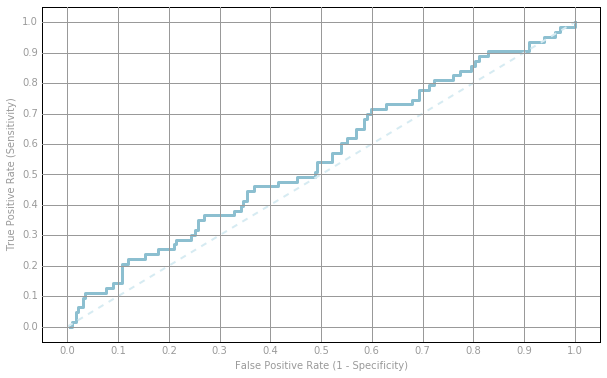

In [31]:
import matplotlib.pyplot as plt

def prepare_plot(xticks, yticks, figsize=(10, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

labelsAndWeights = [[el[0], el[1][1]] for el in df_val_pred_logloss.select("label", "probability").collect()]
labelsAndWeights.sort(key=lambda kv: kv[1], reverse=True)
labelsByWeight = np.array([k for (k, v) in labelsAndWeights])

length = labelsByWeight.size
truePositives = labelsByWeight.cumsum()
numPositive = truePositives[-1]
falsePositives = np.arange(1.0, length + 1, 1.) - truePositives

truePositiveRate = truePositives / numPositive
falsePositiveRate = falsePositives / (length - numPositive)

# Generate layout and plot data
fig, ax = prepare_plot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1))
ax.set_xlim(-.05, 1.05), ax.set_ylim(-.05, 1.05)
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
plt.plot(falsePositiveRate, truePositiveRate, color='#8cbfd0', linestyle='-', linewidth=3.)
plt.plot((0., 1.), (0., 1.), linestyle='--', color='#d6ebf2', linewidth=2.)  # Baseline model
plt.show()

# PART 4 : Reduce feature dimension via feature hashing

## 4.1 Hash function 

As we just saw, using a one-hot-encoding featurization can yield a model with good statistical accuracy.  However, the number of distinct categories across all features is quite large -- recall that we observed  categories in the training data in Part 3.  Moreover, the full Kaggle training dataset includes more than distinct categories, and the 38K Kaggle dataset itself is just a small subset of Criteo's labeled data.  Hence, featurizing via a one-hot-encoding representation would lead to a very large feature vector. To reduce the dimensionality of the feature space, we will use `feature hashing`. See [an explanation here](https://www.quora.com/Can-you-explain-feature-hashing-in-an-easily-understandable-way)

Below is the hash function that we will use to discover features hashing. We will first use this hash function with the three sample data points from Part 1 to gain some intuition.  Specifically :
- Run code to hash the three sample points with `numBuckets` set to `4`. 
- Run code to hash the three sample points with `numBuckets` set to `100`. 
- Observe the resulting hashed feature dictionaries. What do you think of it ?

_Note_ : Don't forget to set `printMapping` on `True` to understand logs.


In [32]:
from collections import defaultdict
import hashlib

def hash_function(numBuckets, rawFeats, printMapping=False):
    """Calculate a feature dictionary for an observation's features based on hashing.

    Note:
        Use printMapping=True for debug purposes and to better understand how the hashing works.

    Args:
        numBuckets (int): Number of buckets to use as features.
        rawFeats (list of (int, str)): A list of features for an observation.  Represented as
            (featureID, value) tuples.
        printMapping (bool, optional): If true, the mappings of featureString to index will be
            printed.

    Returns:
        dict of int to float:  The keys will be integers which represent the buckets that the
            features have been hashed to.  The value for a given key will contain the count of the
            (featureID, value) tuples that have hashed to that key.
    """
    mapping = {}
    for ind, category in rawFeats:
        featureString = category + str(ind)
        mapping[featureString] = int(int(hashlib.md5(featureString.encode('utf-8')).hexdigest(), 16) % numBuckets)
    if(printMapping): print(mapping)
    sparseFeatures = defaultdict(float)
    for bucket in mapping.values():
        sparseFeatures[bucket] += 1.0
    return dict(sparseFeatures)

# Reminder of the sample values:
# sample_one = [(0, 'mouse'), (1, 'black')]
# sample_two = [(0, 'cat'), (1, 'tabby'), (2, 'mouse')]
# sample_three =  [(0, 'bear'), (1, 'black'), (2, 'salmon')]

In [33]:
# TODO: Replace <FILL IN> with appropriate code
# Use four buckets
print("Features hashing with two features :")
samp_one_four_buckets = hash_function(4, sample_one, True)
samp_two_four_buckets = hash_function(4, sample_two, True)
samp_three_four_buckets = hash_function(4, sample_three, True)

# Use one hundred buckets
print("\n Features hashing with one hundred features :")
samp_one_hundred_buckets = hash_function(100, sample_one, True)
samp_two_hundred_buckets = hash_function(100, sample_two, True)
samp_three_hundred_buckets = hash_function(100, sample_three, True)

print('\n\t\t 4 Buckets \t\t\t 100 Buckets')
print('SampleOne:\t {0}\t\t {1}'.format(samp_one_four_buckets, samp_one_hundred_buckets))
print('SampleTwo:\t {0}\t\t {1}'.format(samp_two_four_buckets, samp_two_hundred_buckets))
print('SampleThree:\t {0}\t {1}'.format(samp_three_four_buckets, samp_three_hundred_buckets))

Features hashing with two features :
{'mouse0': 3, 'black1': 2}
{'tabby1': 0, 'mouse2': 2, 'cat0': 0}
{'bear0': 0, 'black1': 2, 'salmon2': 1}

 Features hashing with one hundred features :
{'mouse0': 31, 'black1': 14}
{'tabby1': 16, 'mouse2': 62, 'cat0': 40}
{'bear0': 72, 'black1': 14, 'salmon2': 5}

		 4 Buckets 			 100 Buckets
SampleOne:	 {2: 1.0, 3: 1.0}		 {14: 1.0, 31: 1.0}
SampleTwo:	 {0: 2.0, 2: 1.0}		 {16: 1.0, 40: 1.0, 62: 1.0}
SampleThree:	 {0: 1.0, 1: 1.0, 2: 1.0}	 {72: 1.0, 5: 1.0, 14: 1.0}


In [35]:
# TEST Hash function (4.1)
Test.assertEquals(samp_one_four_buckets, {2: 1.0, 3: 1.0}, 'incorrect value for samp_one_four_buckets')
Test.assertEquals(samp_three_hundred_buckets, {72: 1.0, 5: 1.0, 14: 1.0},
                  'incorrect value for samp_three_hundred_buckets')

1 test passed.
1 test passed.


## 4.2 Features hashing in Spark ML

In Spark ML, it already exists a features hasher based on Austin Appleby’s MurmurHash 3 algorithm [HashingTF](https://spark.apache.org/docs/2.1.0/api/python/pyspark.ml.html#pyspark.ml.feature.HashingTF). Note that its using is not really convenient and requires to wrap all string features into an array. The following code applies the Hashing TF on the previous color dataframe.

In [36]:
from pyspark.sql.functions import concat_ws, split
from pyspark.sql.types import ArrayType
from pyspark.ml.feature import HashingTF

### Creating random color data - 11 different colors - 9 columns - 100 rows : 
all_colors = ["red", "blue", "green", "purple", "yellow", "black", "brown", "grey", "pink", "orange", "white"]
random_colors_data = [[random.choice(all_colors) for i in range(1,10)] for j in range(0,100)]
random_colors_header = ["color_%s" % i for i in range(1,10)]
df_color = sqlContext.createDataFrame(data=random_colors_data, schema=random_colors_header)
print("Original dataframe : ")
df_color.show(5)

### Wrap all string color into an Array named "all_colors" :
df_color = df_color.withColumn("color_array", df_color.color_1) # First step : taking first column
all_cols_except_0 = [color for color in df_color.columns if color != "color_1"]
for col in all_cols_except_0: # Concat all strings
    df_color = df_color.withColumn("color_array", concat_ws(',', df_color.color_array, df_color["%s" % col]))
df_color = df_color.withColumn("color_array", split(df_color.color_array, ",").cast(ArrayType(StringType())))

# Spark ML Hashing TF - 4 features:
hasher = HashingTF(inputCol="color_array", numFeatures=8, outputCol="color_hashed")
df_color = hasher.transform(df_color)
print("After Hashing TF : ")
df_color.select("color_array", "color_hashed").show(5)

Original dataframe : 
+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|color_1|color_2|color_3|color_4|color_5|color_6|color_7|color_8|color_9|
+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|  brown|   pink|  black|  white|  brown|  green|   pink|  black|   blue|
|   grey|   pink| orange|   grey|  brown| purple| purple|  green| purple|
|   pink| orange| purple|  green|  white|   blue|  green|    red|  green|
| purple|  brown|  white|  black|  white|  black|  brown|   grey| purple|
|  green| orange|  green|   grey|  black|  green|  white|   pink| yellow|
+-------+-------+-------+-------+-------+-------+-------+-------+-------+
only showing top 5 rows

After Hashing TF : 
+--------------------+--------------------+
|         color_array|        color_hashed|
+--------------------+--------------------+
|[brown, pink, bla...|(8,[0,1,5],[6.0,6...|
|[grey, pink, oran...|(8,[0,1,3,5,7],[2...|
|[pink, orange, pu...|(8,[0,1,3,5],[2.0...|
|[p

## 4.3 Features Hashing on CTR dataframes

It is now your turn to apply features hashing on aall CTR categorical columns. To achieve this task, feel free to refer to previous question in order to correctly use the Spark ML `HashingTF`.

- First, select all the **string** columns to concat except column `col_string_14`. Assign the resulting to variable `all_cols_except_14`.
- Then, for each of train, validation and test dataframes, create a new column named `string_array` which contains all concated categorical columns. See previous question to achieve this task.
- Finally, create a HashingTF instance with `numFeatures=32768`. Than apply this features hasher on train, validation and test dataframes to create new column named `string_array_hashed`.

_Note_ : In case Spark displays log "column already exists...", you can run the following cell to drop the already created columns.

In [37]:
# In case of issue "column already exists..."
df_train = df_train.drop("string_array_hashed")
df_val = df_val.drop("string_array_hashed")
df_test = df_test.drop("string_array_hashed")

In [38]:
from pyspark.sql.functions import concat_ws, split
from pyspark.sql.types import ArrayType
from pyspark.ml.feature import HashingTF

# Select all columns to concat except `col_string_14` :
all_cols_except_14 = ["col_string_%s" % i for i in range(15, 40)]

# Process Train Dataframe
df_train = df_train.withColumn("string_array", df_train.col_string_14) # Create empty col
for col in all_cols_except_14: # Concat all strings
    df_train = df_train.withColumn("string_array", concat_ws(',', df_train.string_array, df_train["%s" % col]))
df_train = df_train.withColumn("string_array", split(df_train.string_array, ",").cast(ArrayType(StringType())))

# Process Validation Dataframe
df_val = df_val.withColumn("string_array", df_val.col_string_14) # Create empty col
for col in all_cols_except_14: # Concat all strings
    df_val = df_val.withColumn("string_array", concat_ws(',', df_val.string_array, df_val["%s" % col]))
df_val = df_val.withColumn("string_array", split(df_val.string_array, ",").cast(ArrayType(StringType())))

# Process Train Dataframe
df_test = df_test.withColumn("string_array", df_test.col_string_14) # Create empty col
for col in all_cols_except_14: # Concat all strings
    df_test = df_test.withColumn("string_array", concat_ws(',', df_test.string_array, df_test["%s" % col]))
df_test = df_test.withColumn("string_array", split(df_test.string_array, ",").cast(ArrayType(StringType())))

# Spark ML Hashing TF - 32768 features:
hasher = HashingTF(inputCol="string_array", numFeatures=32768, outputCol="string_array_hashed")
df_train = hasher.transform(df_train.cache())
df_val = hasher.transform(df_val.cache())
df_test = hasher.transform(df_test.cache())
print("After Hashing TF : ")
df_train.select("label", "string_array", "string_array_hashed").show(5)

After Hashing TF : 
+-----+--------------------+--------------------+
|label|        string_array| string_array_hashed|
+-----+--------------------+--------------------+
|  0.0|[05db9164, 1cfdf7...|(32768,[4583,5490...|
|  0.0|[05db9164, 3f0d3f...|(32768,[857,2902,...|
|  0.0|[05db9164, 89ddfe...|(32768,[414,1936,...|
|  0.0|[05db9164, 58e67a...|(32768,[316,685,7...|
|  0.0|[5a9ed9b0, 4c2bc5...|(32768,[857,2657,...|
+-----+--------------------+--------------------+
only showing top 5 rows



In [39]:
# TEST Features hashing on CTR dataframes (4.3)
Test.assertTrue("string_array" in df_train.columns, "missing string_array col in train dataframe")
Test.assertTrue("string_array" in df_val.columns, "missing string_array col in validation dataframe")
Test.assertTrue("string_array" in df_test.columns, "missing string_array col in test dataframe")
Test.assertTrue("string_array_hashed" in df_train.columns, "missing string_array_hashed col in train dataframe")
Test.assertTrue("string_array_hashed" in df_val.columns, "missing string_array_hashed col in validation dataframe")
Test.assertTrue("string_array_hashed" in df_test.columns, "missing string_array_hashed col in test dataframe")
Test.assertEquals(len(df_train.select("string_array").take(2)[0][0]), 26, "train df string_array expects 26 elements")
Test.assertEquals(len(df_val.select("string_array").take(2)[0][0]), 26, "val df string_array expects 26 elements")
Test.assertEquals(len(df_test.select("string_array").take(2)[0][0]), 26, "test df string_array expects 26 elements")
Test.assertEquals(len(df_train.select("string_array_hashed").take(2)[0][0]), 32768, "train df string_array_hashed expects 32768 elements")
Test.assertEquals(len(df_val.select("string_array_hashed").take(2)[0][0]), 32768, "val df string_array_hashed expects 32768 elements")
Test.assertEquals(len(df_test.select("string_array_hashed").take(2)[0][0]), 32768, "test df string_array_hashed expects 32768 elements")

1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.


## 4.4 Vector Assembler

Let us now assemble our new features before training machine learning algorithm. Using a `VectorAssembler`, create a new column named `features_2` for each of train, validation and test dataframes. Column `features_2` has to contain column `string_array_hashed` and all the continuous (float) columns. 

- Select all the columns names to assemble and assign it to variable `columns_to_assemble`.
- Define a VectorAssembler instance and use it on each of train, validation and test dataframes.

_Note_ : In case Spark displays log "column already exists...", you can run the following cell to drop the already created columns.

In [40]:
# In case of issue "column already exists..."
df_train = df_train.drop("features_2")
df_val = df_val.drop("features_2")
df_test = df_test.drop("features_2")

In [41]:
from pyspark.ml.feature import VectorAssembler
columns_to_assemble = ["string_array_hashed"] + [col for col in df_train.columns if "float" in col]
vect_assembler = VectorAssembler(inputCols=columns_to_assemble, outputCol="features_2")
df_train = vect_assembler.transform(df_train)
df_val = vect_assembler.transform(df_val)
df_test = vect_assembler.transform(df_test)

In [42]:
# Test Vector Assembler
Test.assertEquals(len(columns_to_assemble), 14, "incorrect variable columns_to_assemble")
Test.assertTrue("features_2" in df_train.columns, "missing features_2 col in train dataframe")
Test.assertTrue("features_2" in df_val.columns, "missing features_2 col in validation dataframe")
Test.assertTrue("features_2" in df_test.columns, "missing features_2 col in test dataframe")

1 test passed.
1 test passed.
1 test passed.
1 test passed.


## 4.5 Machine Learning

We are now ready to train our second CTR classifier with news hashed features. 

- First, create a [LogisticRegression](https://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark.ml.classification.LogisticRegression) instance. Set the hyperameters such as defined in below note.
- Then, train the machine learning algorithm and assign the resulting model to variable _model_.
- Finally, make predictions on both train and validation set. Assign the resulting dataframe to variables **df_train_pred** and **df_val_pred**. Print the validation dataframe on the standard output using method _.show()_.

_Note_ : Because we deal with a huge amount of different features, it is highly recommended to use regularization to avoid overfitting. 

_Note_ : Concerning logistic regression hyperparameters, use a L2 regularization with strength 10 and 2 maximum iterations and set _fitIntercept_ to True. Other hyperparameters have to be set default.

_Note_ : Remember that after each action, Spark RDD and dataframes are automatically uncached. Because a machine learning algorithm is a heavy process, don't forget to `cache` again your train dataframe before training algorithm.

_Note_ : Results will certainly be worth that for previous logistic regression. Do not care for the moment.

In [73]:
from pyspark.ml.classification import LogisticRegression

# Train a logistic regression on train dataframe : 
lr = LogisticRegression(featuresCol="features_2", labelCol="label", fitIntercept=True, maxIter=2,
                        elasticNetParam=1.0, regParam=10)
df_train = df_train.cache()
model = lr.fit(df_train)

# Make prediction on validation dataframe and show it :
df_train_pred = model.transform(df_train)
df_val_pred = model.transform(df_val)

df_train_pred_logloss = df_train_pred.withColumn("logloss", my_udf("probability", "label"))
mean_log_loss_train = df_train_pred_logloss.select(mean(df_train_pred_logloss.logloss)).collect()[0][0]

df_val_pred_logloss = df_val_pred.withColumn("logloss", my_udf("probability", "label"))
mean_log_loss_val = df_val_pred_logloss.select(mean(df_val_pred_logloss.logloss)).collect()[0][0]

print("Mean log loss on train dataset : %s" % mean_log_loss_train)
print("Mean log loss on validation dataset : %s" % mean_log_loss_val)

Mean log loss on train dataset : 0.5287504103268208
Mean log loss on validation dataset : 0.5343640827395868


In [75]:
# TEST Machine Learning (4.5)
Test.assertEquals(df_train.is_cached, True, "do not forget to cache train dataframe.")
Test.assertEquals(lr.getOrDefault("labelCol"), "label", "incorect labelCol parameter")
Test.assertEquals(lr.getOrDefault("featuresCol"), "features_2", "incorect featuresCol parameter")
Test.assertEquals(lr.getOrDefault("fitIntercept"), True, "incorect fitIntercept parameter")
Test.assertEquals(lr.getOrDefault("maxIter"), 2, "incorect maxIter parameter")
Test.assertEquals(lr.getOrDefault("elasticNetParam"), 0.0, "incorect elasticNetParam parameter")
Test.assertEquals(lr.getOrDefault("regParam"), 10, "incorect regParam parameter")
Test.assertTrue("probability" in df_train_pred.columns, "missing transformation for train dataframe.")
Test.assertTrue("probability" in df_val_pred.columns, "missing transformation for validation dataframe.")
Test.assertEquals(round(mean_log_loss_train, 2), 0.47, "Incorrect mean log loss for train dataset")
Test.assertEquals(round(mean_log_loss_val, 2), 0.51, "Incorrect mean log loss for validation dataset")

1 test passed.
1 test passed.
1 test failed. incorect featuresCol parameter
1 test passed.
1 test failed. incorect maxIter parameter
1 test passed.
1 test failed. incorect regParam parameter
1 test passed.
1 test passed.
1 test failed. Incorrect mean log loss for train dataset
1 test failed. Incorrect mean log loss for validation dataset


## 4.5 Design a hyperparameters tuning grid

As you may have noticed, this new algorithm results are not better than the previous one. This is due to the many hyperparameters we can use to correctly set our model. To find a suitable combination for the new hased features :

First, design a grid search composed of following hyperparatemers range : 
- _maxIter_ : [2]
- _elasticNetParam_ : [0.5, 0.8]
- _regParam_ : [0.01, 0.1, 0.5]

Then, Create a _CrossValidator_ instance with :
- parameter _estimator_ = _lr_.
- parameter estimatorParamMaps_ = _grid_.
- evaluator = _BinaryClassificationEvaluator(metricsName=metricName="areaUnderROC")_

Finally, train the grid on train dataframe and assign the followinf result to variable `cvModel`.

_Note_ : You can reach information about how to build grid and CrossValidators [here](https://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#module-pyspark.ml.tuning).

_Note_ : Log Loss function is not currently implemented as a pyspark ML evaluator. Without log loss metrics, we have to choose an other default metrics for the Grid design (AreaUnderRoc). Once we will find suitable hyperparameters, we will run the model and evaluate the log loss metrics.

_Note_ : Remember that after each action, Spark RDD and dataframes are automatically uncached. Because a machine learning algorithm is a heavy process, don't forget to `cache` again your train dataframe before training algorithm.

_Note_ : Grid may takes several minutes to run.

In [74]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lr = LogisticRegression()
grid = ParamGridBuilder() \
     .baseOn({lr.featuresCol: 'features_2'}) \
     .baseOn({lr.labelCol: 'label'}) \
     .baseOn([lr.predictionCol, 'prediction']) \
     .addGrid(lr.maxIter, [2]) \
     .addGrid(lr.elasticNetParam, [0.5, 0.8]) \
     .addGrid(lr.regParam, [0.01, 0.1, 0.5]) \
     .build()
        
evaluator = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator)
cvModel = cv.fit(df_train.cache())

## 4.6 Evaluate the grid Model

Once a grid is trained using Spark CrossValidator, best model is saved and can be used using method _.transform()_. We can now make predictions for both train, validation and test datasets. 

- Compute these predictions and assign the resulting to variables **df_train_pred**, **df_val_pred**, **df_test_pred**.
- Compute The mean log loss for each of these dataframes and assign the results to variables **mean_log_loss_train**, **mean_log_loss_val** and **mean_log_loss_test**.

In [76]:
# TODO: Replace <FILL IN> with appropriate code
from pyspark.sql.functions import mean

df_train_pred = cvModel.transform(df_train)
df_val_pred = cvModel.transform(df_val)
df_test_pred = cvModel.transform(df_test)

df_train_pred_logloss = df_train_pred.withColumn("logloss", my_udf("probability", "label"))
mean_log_loss_train = df_train_pred_logloss.select(mean(df_train_pred_logloss.logloss)).collect()[0][0]

df_val_pred_logloss = df_val_pred.withColumn("logloss", my_udf("probability", "label"))
mean_log_loss_val = df_val_pred_logloss.select(mean(df_val_pred_logloss.logloss)).collect()[0][0]

df_test_pred_logloss = df_test_pred.withColumn("logloss", my_udf("probability", "label"))
mean_log_loss_test = df_test_pred_logloss.select(mean(df_test_pred_logloss.logloss)).collect()[0][0]

print("Mean log loss on train dataset : %s" % mean_log_loss_train)
print("Mean log loss on validation dataset : %s" % mean_log_loss_val)
print("Mean log loss on Test dataset : %s" % mean_log_loss_test)

Mean log loss on train dataset : 0.4261399533971181
Mean log loss on validation dataset : 0.452331596219578
Mean log loss on Test dataset : 0.5018769700388688


In [81]:
Test.assertEquals(round(mean_log_loss_train, 2), 0.43, "Incorrect mean log loss for train dataset")
Test.assertEquals(round(mean_log_loss_val, 2), 0.45, "Incorrect mean log loss for validation dataset")
Test.assertEquals(round(mean_log_loss_test, 2), 0.50, "Incorrect mean log loss for test dataset")

1 test passed.
1 test passed.
1 test passed.


## Conclusion

you have now reached the end of the lab. You can compare your final score with the offical Kaggle competition leaderboard. Keep in mind you have only used a small subset of data and a really simple logistic regression mode. Using an Hadoop cluster, you would be able to adress these issues.

Kaggle Learderboard : https://www.kaggle.com/c/criteo-display-ad-challenge/leaderboard